In [3]:
import torch
import torch_geometric
import torch_geometric.nn as pyg_nn
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.data
from torch_geometric.datasets import Twitch, GitHub, GNNBenchmarkDataset
import networkx as nkx

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [108]:
class Preprocessor(nn.Module):
    """
    Препроцессинг признаков без учета структурных связей в графе.

    Используется для преобразования неструтурированных данных (текст, изображения) в векторные представления.
    """
    def __init__(self):
        super().__init__()

    def forward():
        pass


class SeqGINBlock(nn.Module):
    """
    Блок, содержащий последовательные графовые слои, реализующие трансформацию и агрегацию признаков от соседних вершин.
    В данной реализации используются GIN свертки, использующие нейронных блок для агрегации функцией,
    обладающей свойством инъективности (как хеш-функция), к тому же используются skip-connection-ы.
    """
    def __init__(self, inp_dim: int, out_dim: int):
        super().__init__()
        self.last_gnn_out_dim = 32
        self.layer1 = pyg_nn.GINConv(
            nn.Sequential(
                nn.Linear(inp_dim, 128),
                nn.ReLU(),
                nn.BatchNorm1d(128),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.BatchNorm1d(64),
            )
        )

        self.layer2 = pyg_nn.GINConv(
            nn.Sequential(
                nn.Linear(64, 64),
                nn.ReLU(),
                nn.BatchNorm1d(64),
                nn.Linear(64, 64),
                nn.ReLU(),
                nn.BatchNorm1d(64),
            )
        )

        self.layer3 = pyg_nn.GINConv(
            nn.Sequential(
                nn.Linear(64, 64),
                nn.ReLU(),
                nn.BatchNorm1d(64),
                nn.Linear(64, 64),
                nn.ReLU(),
                nn.BatchNorm1d(64),
            )
        )

        self.layer4 = pyg_nn.GINConv(
            nn.Sequential(
                nn.Linear(64, 64),
                nn.ReLU(),
                nn.BatchNorm1d(64),
                nn.Linear(64, 64),
                nn.ReLU(),
                nn.BatchNorm1d(64),
            )
        )

        self.layer5 = pyg_nn.GINConv(
            nn.Sequential(
                nn.Linear(64, 64),
                nn.ReLU(),
                nn.BatchNorm1d(64),
                nn.Linear(64, 64),
                nn.ReLU(),
                nn.BatchNorm1d(64),
            )
        )

        self.layer6 = pyg_nn.GINConv(
            nn.Sequential(
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.BatchNorm1d(32),
                nn.Linear(32, self.last_gnn_out_dim),
                nn.ReLU(),
                nn.BatchNorm1d(self.last_gnn_out_dim),
            )
        )

        self.prediction_head = nn.Linear(self.last_gnn_out_dim, out_dim)

    def forward(self, data):
        h0, edge_index = data.x, data.edge_index
        h0 = F.normalize(h0, dim=1)
        h1 = self.layer1(h0, edge_index)
        #h2 = self.layer2(h1, edge_index)
        #h3 = self.layer3(h2, edge_index)
        #h4 = self.layer4(F.relu(h3 + h1), edge_index)
        #h5 = self.layer5(F.relu(h4 + h2), edge_index)
        z = F.dropout(self.layer6(h1, edge_index), p=0.4, training=self.training)
        return self.prediction_head(z)

class SeqGCNBlock(nn.Module):
    def __init__(self, inp_dim: int, out_dim: int):
        super().__init__()
        self.last_gnn_out_dim = 32
        self.layer1 = pyg_nn.GCNConv(inp_dim, 64)
        self.layer2 = pyg_nn.GCNConv(64, 64)
        self.layer3 = pyg_nn.GCNConv(64, self.last_gnn_out_dim)
        self.prediction_heead = nn.Linear(self.last_gnn_out_dim, out_dim)

    def forward(self, data):
        h0, edge_index = data.x, data.edge_index
        h0 = F.normalize(h0, dim=1)
        h1 = self.layer1(h0, edge_index)
        h1 = F.dropout(h1, p=0.25, training=self.training)
        h2 = self.layer2(h1, edge_index)
        h2 = F.dropout(h2, p=0.25, training=self.training)
        z = self.layer3(F.relu(h2 + h1), edge_index)
        return self.prediction_heead(z)

class SeqGATBlock(nn.Module):
    pass

class PostProcessor(nn.Module):
    """
    Постпроцессинг, обобщение информации о представлениях вершин
    """
    def __init__(self, inp_dim: int, out_dim: int):
        super().__init__()


    def forward(self, x):
        return x


class ComplexGNN(nn.Module):
    def __init__(
        self, 
        use_preproc=True, 
        use_postproc=True, 
        preproc_inp_dim=None,  
        gnnblock_inp_dim=None, 
        postproc_inp_dim=None
        ):

        self.PreprocessBlock = Preprocessor(preproc_inp_dim, gnnblock_inp_dim) if use_preproc else None
        self.GNNBlock = GNNBlock(gnnblock_inp_dim, postproc_inp_dim or 1)
        self.PostprocessBlock = PostProcessor(postproc_inp_dim, 1) if use_postproc else None

    def forward(self, data: torch_geometric.data.Data):
        if self.PreprocessBlock is not None:
            x = self.PreprocessBlock(data.x)
        x = self.GNNBlock(data)
        if self.PostprocessBlock is not None:
            x = self.PostprocessBlock(data.x)
        return x # remember to apply BCEWithLogits instead of BCE


# SeqGIN Benchmark

100%|██████████| 1500/1500 [01:01<00:00, 24.53it/s]


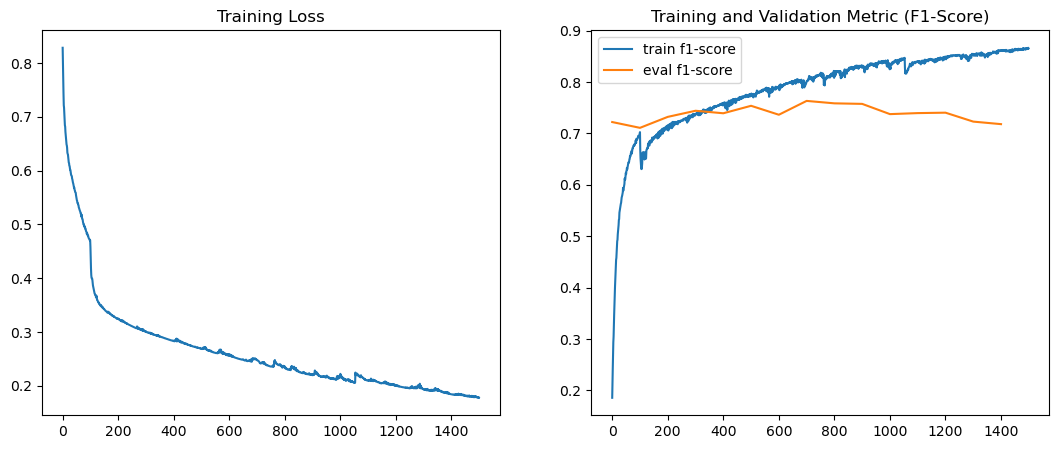

In [101]:
from common import train_model, eval_model, plot_hist
from torch_geometric.transforms import RandomNodeSplit

torch.manual_seed(42)

data = RandomNodeSplit()(GitHub('../data/GitHub/').data.to(DEVICE))
data.y = data.y.to(torch.float32) # for loss computation
model = SeqGINBlock(data.num_features, 1).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)
loss = nn.BCEWithLogitsLoss()
eval_freq = 100
train_hist = train_model(model, loss, optimizer, data, epochs=1500, eval_freq=eval_freq, log_stats=False)
plot_hist(*train_hist, eval_freq=eval_freq)

In [102]:
from common import benchmark_model

benchmark_model(model, data, apply_test_mask=True, device=DEVICE)

{'recall': 0.6264591217041016,
 'precision': 0.7318181991577148,
 'f1-score': 0.6750524044036865}

100%|██████████| 700/700 [00:13<00:00, 50.94it/s]


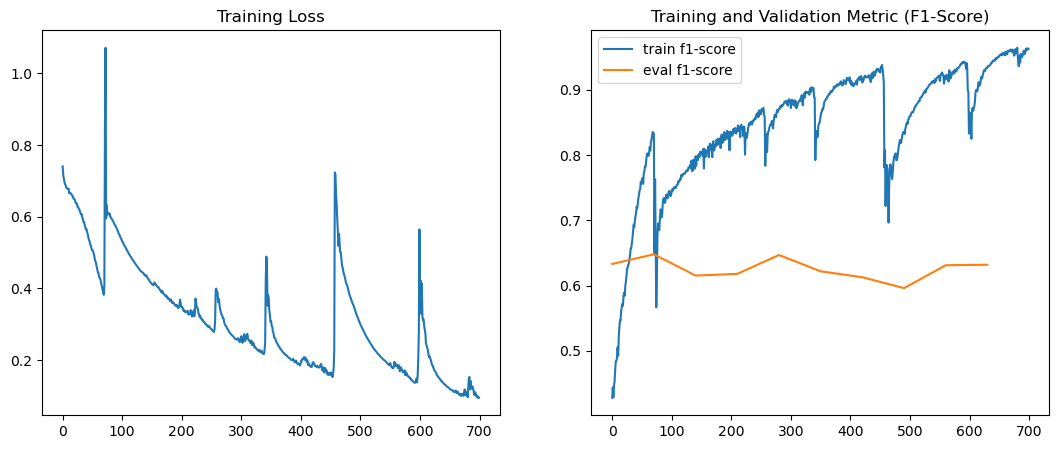

In [103]:
from common import train_model, eval_model, plot_hist
from torch_geometric.transforms import RandomNodeSplit

torch.manual_seed(42)

data = RandomNodeSplit()(Twitch('../data/Twitch/', name='EN').data.to(DEVICE))
data.y = data.y.to(torch.float32) # for loss computation
model = GNNBlock(data.num_features, 1).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
loss = nn.BCEWithLogitsLoss()

train_hist = train_model(model, loss, optimizer, data, epochs=700, eval_freq=70, log_stats=False)
plot_hist(*train_hist, eval_freq=70)

In [104]:
benchmark_model(model, data, apply_test_mask=True, device=DEVICE)

{'recall': 0.6178107857704163,
 'precision': 0.5904255509376526,
 'f1-score': 0.603807806968689}

# SeqGCN benchmark

100%|██████████| 1500/1500 [01:25<00:00, 17.59it/s]


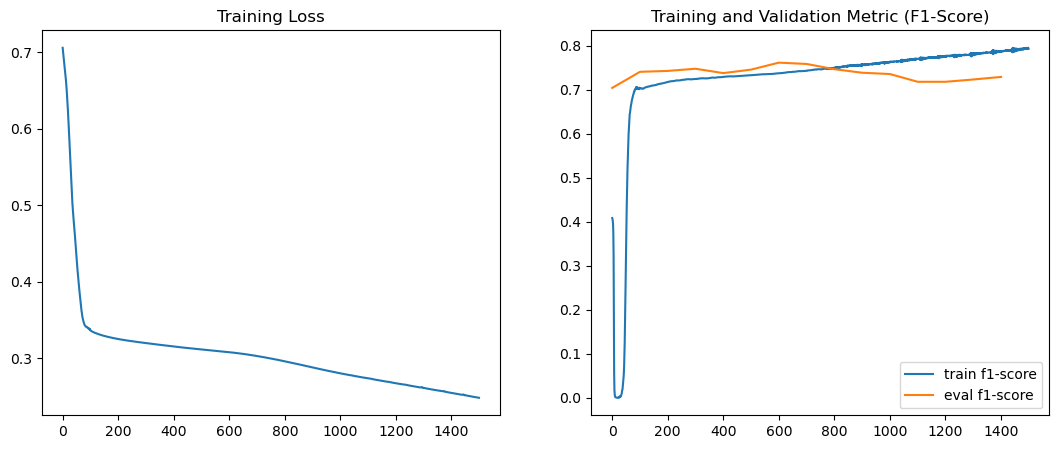

In [111]:
from common import train_model, eval_model, plot_hist
from torch_geometric.transforms import RandomNodeSplit

torch.manual_seed(42)

data = RandomNodeSplit()(GitHub('../data/GitHub/').data.to(DEVICE))
data.y = data.y.to(torch.float32) # for loss computation
model = SeqGCNBlock(data.num_features, 1).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
loss = nn.BCEWithLogitsLoss()
eval_freq = 100
train_hist = train_model(model, loss, optimizer, data, epochs=1500, eval_freq=eval_freq, log_stats=False)
plot_hist(*train_hist, eval_freq=eval_freq)

In [112]:
benchmark_model(model, data, apply_test_mask=True, device=DEVICE)

{'recall': 0.6342412233352661,
 'precision': 0.7117903828620911,
 'f1-score': 0.6707818508148193}

100%|██████████| 1500/1500 [00:26<00:00, 55.74it/s]


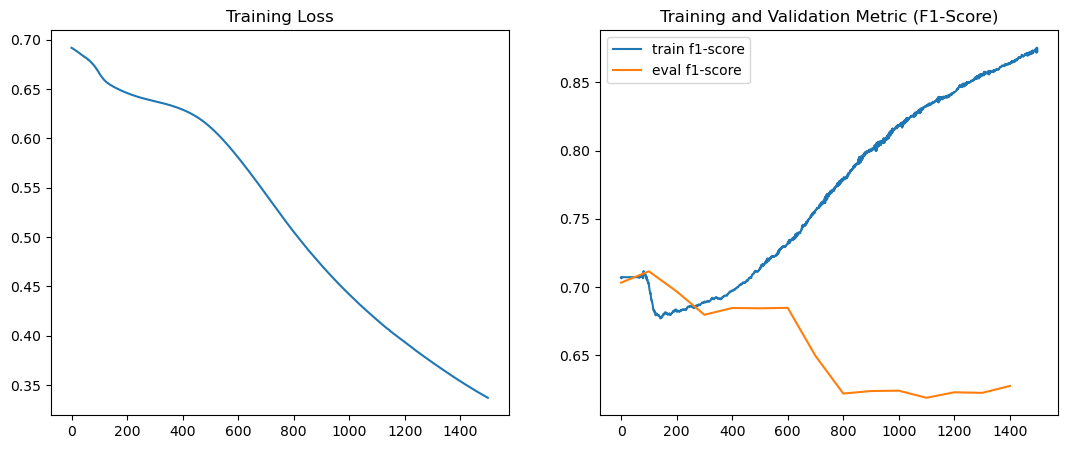

In [120]:
from common import train_model, eval_model, plot_hist
from torch_geometric.transforms import RandomNodeSplit

torch.manual_seed(42)

data = RandomNodeSplit()(Twitch('../data/Twitch/', name='EN').data.to(DEVICE))
data.y = data.y.to(torch.float32) # for loss computation
model = SeqGCNBlock(data.num_features, 1).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)
loss = nn.BCEWithLogitsLoss()
eval_freq = 100
train_hist = train_model(model, loss, optimizer, data, epochs=1500, eval_freq=eval_freq, log_stats=False)
plot_hist(*train_hist, eval_freq=eval_freq)

In [121]:
benchmark_model(model, data, apply_test_mask=True, device=DEVICE)

{'recall': 0.6345083713531494,
 'precision': 0.6118068099021912,
 'f1-score': 0.6229507923126221}

Вывод: что-то не так с этим твичом, нужно добавить график лоса в трейн, а то нихрена не понятно